## Master Data Preparation for Statistical Analysis

This Jupyter notebook merges processed books and authors datasets, and prepares the master data for performing hypothesis testing, including basic data cleaning and feature generation.

#### Import Libraries

In [63]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Upload & Merge

In [64]:
books_path = "C:\\Users\\juhic\\OneDrive\\Desktop\\books_processed.csv"
authors_path = "C:\\Users\\juhic\\OneDrive\\Desktop\\authors_processed.csv"
books = pd.read_csv(books_path)
authors = pd.read_csv(authors_path)

books.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)
authors.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

data = pd.merge(left = books, right = authors, how = 'inner', on = 'author')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35121 entries, 0 to 35120
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                35121 non-null  object 
 1   series               17959 non-null  object 
 2   author               35121 non-null  object 
 3   rating_count         35121 non-null  int64  
 4   review_count         35121 non-null  int64  
 5   average_rating       35121 non-null  float64
 6   five_star_ratings    35121 non-null  int64  
 7   four_star_ratings    35121 non-null  int64  
 8   three_star_ratings   35121 non-null  int64  
 9   two_star_ratings     35121 non-null  int64  
 10  one_star_ratings     35121 non-null  int64  
 11  page_count           35121 non-null  float64
 12  published_year       35121 non-null  int64  
 13  genre                35121 non-null  object 
 14  is_volume            35121 non-null  object 
 15  sex                  35121 non-null 

#### Type Conversions

In [65]:
cols = ['page_count','author_rating_count','work_count']
for c in cols:
    data.loc[data[c].isna(),c] = 0
    data[c] = data[c].astype(int)

#### Data Cleaning

In [66]:
# Fixing duplicate author information

x = data[['author','work_count']].drop_duplicates()
t = x['author'].value_counts()
t.head(10)

alexis hall        2
j.a. baker         2
morgan parker      2
lee smith          2
robin hardy        2
samantha berger    1
emma smith         1
asa don brown      1
nancy atherton     1
paul muldoon       1
Name: author, dtype: int64

In [67]:
i1 = data[(data['author'] == 'alexis hall') & (data['sex'] == 'female')].index
i2 = data[(data['author'] == 'j.a. baker') & (data['sex'] == 'male')].index
i3 = data[(data['author'] == 'morgan parker') & (data['sex'] == 'male')].index
i4 = data[(data['author'] == 'lee smith') & (data['sex'] == 'male')].index
i5 = data[(data['author'] == 'robin hardy') & (data['sex'] == 'female')].index

data.drop(axis = 0, index = i1, inplace = True)
data.drop(axis = 0, index = i2, inplace = True)
data.drop(axis = 0, index = i3, inplace = True)
data.drop(axis = 0, index = i4, inplace = True)
data.drop(axis = 0, index = i5, inplace = True)

In [70]:
# Dropping columns that are not required
drop_cols = ['series',
             'review_count',
             'average_rating',
             'five_star_ratings',
             'four_star_ratings',
             'three_star_ratings',
             'two_star_ratings',
             'one_star_ratings',
             'author_review_count',
             'published_year',
             'author_rating_count']
data.drop(axis = 1, columns = drop_cols, inplace = True)

data.rename(columns = {'title':'book',
                       'work_count':'author_work_count',
                       'sex':'author_sex'}, inplace = True)

# Removing non-book records (audiobooks, collections poetry etc.)
mask1 = data['page_count'] < 10
mask2 = data['page_count'] >= 5000
data.drop(axis = 0, index = data[mask1 | mask2].index, inplace = True)

list_genre = ['audiobook','poetry','plays']
data.drop(axis = 0, index = data[data['genre'].isin(list_genre)].index, inplace = True)

list_books = ['series','box set','boxed set','volume set','vol.set','volumes','complete collection']
data.drop(axis = 0, index = data[data['book'].isin(list_books)].index, inplace = True)
data.head()

,book,author,rating_count,page_count,genre,is_volume,author_sex,author_work_count,author_avg_rating
0,inner circle,kate brian,7597,220,young adult,yes,female,40,3.93
1,ambition,kate brian,6719,279,young adult,yes,female,40,3.93
2,revelation,kate brian,7431,249,young adult,yes,female,40,3.93
3,legacy,kate brian,7010,243,young adult,yes,female,40,3.93
4,vanished,kate brian,3724,204,young adult,yes,female,40,3.93


#### Feature Extraction: Classification for Author work experience and Book page count.

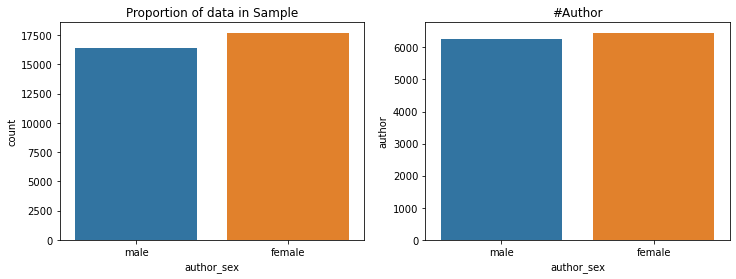

In [71]:
#1. Author Sex

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

sns.countplot(data = data, x = 'author_sex', order = ['male','female'], ax = ax[0])
ax[0].set_title('Proportion of data in Sample')

sex = data[['author','author_sex']].drop_duplicates().groupby(by = 'author_sex').agg({'author':'count'}).reset_index()
sns.barplot(x = 'author_sex', y = 'author', data = sex, order = ['male','female'], ax = ax[1])
ax[1].set_title('#Author')

plt.show()

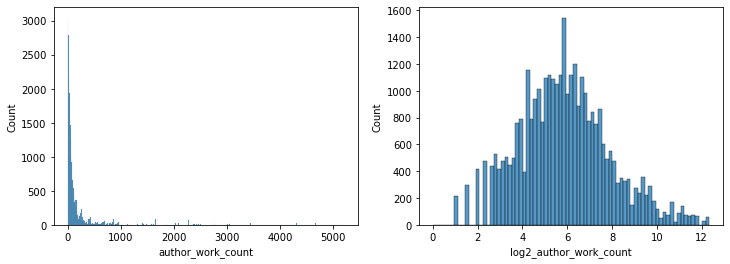

In [72]:
# Author Work Experience

data['log2_author_work_count'] = data['author_work_count'].apply(lambda x: math.log2(x+1))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
sns.histplot(data = data, x = 'author_work_count', ax = ax[0])
sns.histplot(data = data, x = 'log2_author_work_count', ax = ax[1])
plt.show()

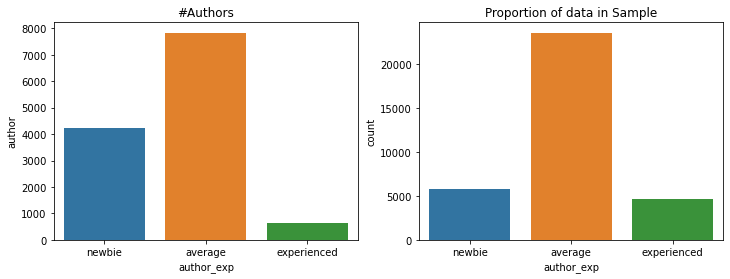

In [73]:
def classify_work_exp(x):
    if x < 4:
        return 'newbie'
    elif x >= 4 and x <= 8:
        return 'average'
    else:
        return 'experienced'
    
data['author_exp'] = data['log2_author_work_count'].apply(func = lambda x: classify_work_exp(x))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

exp = data[['author','author_exp']].drop_duplicates().groupby(by = 'author_exp').agg({'author':'count'}).reset_index()
sns.barplot(x = 'author_exp', y = 'author', data = exp, order = ['newbie', 'average', 'experienced'], ax =  ax[0])
ax[0].set_title('#Authors')

sns.countplot(data = data, x = 'author_exp', order = ['newbie', 'average', 'experienced'], ax = ax[1])
ax[1].set_title('Proportion of data in Sample')

plt.show()

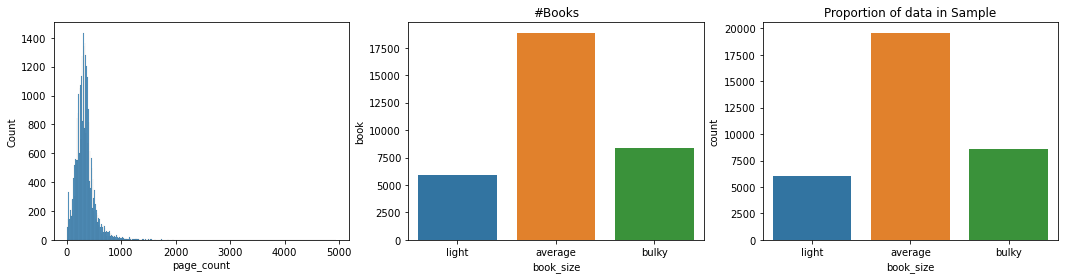

In [74]:
#3. Book Size

def classify_book_size(x):
    if x < 200:
        return 'light'
    elif x >= 200 and x <= 400:
        return 'average'
    else:
        return 'bulky'
    
data['book_size'] = data['page_count'].apply(func = lambda x: classify_book_size(x))

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4))

sns.histplot(data = data, x = 'page_count', ax = ax[0])

size = data[['book','book_size']].drop_duplicates().groupby(by = 'book_size').agg({'book':'count'}).reset_index()
sns.barplot(x = 'book_size', y = 'book', data = size, order = ['light', 'average', 'bulky'], ax =  ax[1])
ax[1].set_title('#Books')

sns.countplot(data = data, x = 'book_size', order = ['light', 'average', 'bulky'], ax = ax[2])
ax[2].set_title('Proportion of data in Sample')

plt.show()

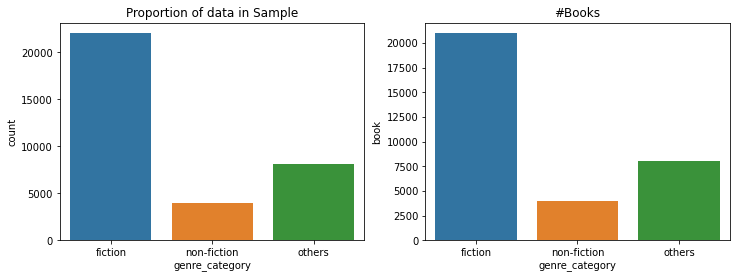

In [75]:
#4. Genre Mapping
genre = pd.read_csv('C:\\Users\\juhic\\OneDrive\\Desktop\\genre mapping.csv')
data_merged = pd.merge(left = data, right = genre, how = 'inner', on = 'genre')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

sns.countplot(data = data_merged, x = 'genre_category', order = ['fiction', 'non-fiction', 'others'], ax = ax[0])
ax[0].set_title('Proportion of data in Sample')

genre=data_merged[['book','genre_category']].drop_duplicates().groupby(by='genre_category').agg({'book':'count'}).reset_index()
sns.barplot(x = 'genre_category', y = 'book', data = genre, order = ['fiction', 'non-fiction', 'others'], ax = ax[1])
ax[1].set_title('#Books')
plt.show()

#### Data Download

In [76]:
data_merged.head()

,book,author,rating_count,page_count,genre,is_volume,author_sex,author_work_count,author_avg_rating,log2_author_work_count,author_exp,book_size,genre_category
0,inner circle,kate brian,7597,220,young adult,yes,female,40,3.93,5.357552,average,average,fiction
1,ambition,kate brian,6719,279,young adult,yes,female,40,3.93,5.357552,average,average,fiction
2,revelation,kate brian,7431,249,young adult,yes,female,40,3.93,5.357552,average,average,fiction
3,legacy,kate brian,7010,243,young adult,yes,female,40,3.93,5.357552,average,average,fiction
4,vanished,kate brian,3724,204,young adult,yes,female,40,3.93,5.357552,average,average,fiction


In [77]:
# Download merged dataset
data_merged.to_csv('master_dataset.csv')